In [1]:
import os
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
!pwd

/home/masha/Desktop/DataScience/GNN/Project/GNN-NLP/notebooks


In [4]:
news = pd.read_json('../../../KEDatasets/KPTimes/KPTimes.train.jsonl', lines=True)

In [5]:
news.head(2)

,id,categories,date,title,abstract,keyword
0,ny0282969,"[us, politics]",2016-07-21,"For Donald Trump’s Big Speech, an Added Pressu...","CLEVELAND — Until Monday night, Donald J. Trum...",2016 Presidential Election;Donald Trump;Republ...
1,ny0225578,"[sports, hockey]",2010-10-16,"In Home Opener, Rangers Lose Gaborik and Drury...",There were silver linings to the Rangers ’ wil...,Hockey Ice;Toronto Maple Leafs;New York Ranger...


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [8]:
import time
from datetime import datetime

In [9]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [10]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [11]:
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [12]:
import fasttext as ft

In [13]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

In [14]:
ft_model.get_nearest_neighbors('man')

[(0.7125452756881714, 'woman'),
 (0.7092046141624451, 'stranger'),
 (0.7067620754241943, 'stupider'),
 (0.7021083235740662, 'thing'),
 (0.7005878686904907, 'darndest'),
 (0.6971448063850403, 'stupidest'),
 (0.692797839641571, 'beastly'),
 (0.6923372745513916, 'beast'),
 (0.6917076110839844, 'hater'),
 (0.6898659467697144, 'niggardly')]

In [15]:
news['abstract'].duplicated().sum(), news.isnull().sum()

(21,
 id            0
 categories    0
 date          0
 title         0
 abstract      0
 keyword       0
 dtype: int64)

In [16]:
news = news.drop_duplicates(subset='abstract').reset_index(drop=True)
news['keyword'] = news['keyword'].str.split(';')
news = news.explode('categories')
news['categories'].value_counts()

sports              61996
world               50828
business            49690
us                  41124
nyregion            40131
                    ...  
businessspecial6        1
worldspecial3           1
nyregionspecial         1
nyregionspecial5        1
election-news           1
Name: categories, Length: 92, dtype: int64

In [17]:
np.random.seed(42)
topics = ['sports', 'world', 'business']
sports_id = news.loc[news['categories'] == 'sports'].index
world_id = news.loc[news['categories'] == 'world'].index
bus_id = news.loc[news['categories'] == 'business'].index
id1 = np.random.choice(sports_id, 20, replace=False).tolist()
id2 = np.random.choice(world_id, 20, replace=False).tolist()
id3 = np.random.choice(bus_id, 20, replace=False).tolist()
ids = id1 + id2 + id3
df = news[['abstract', 'categories', 'keyword']].loc[ids].copy()

In [18]:
df.shape

(108, 3)

In [19]:
df = df.drop_duplicates('abstract').reset_index(drop=True)
df.shape

(60, 3)

In [20]:
preps = [
  "a",
  "abaft",
  "aboard",
  "about",
  "above",
  "absent",
  "across",
  "afore",
  "after",
  "against",
  "along",
  "alongside",
  "amid",
  "amidst",
  "among",
  "amongst",
  "an",
  "anenst",
  "apropos",
  "apud",
  "around",
  "as",
  "aside",
  "astride",
  "at",
  "athwart",
  "atop",
  "barring",
  "before",
  "behind",
  "below",
  "beneath",
  "beside",
  "besides",
  "between",
  "beyond",
  "but",
  "by",
  "circa",
  "concerning",
  "despite",
  "down",
  "during",
  "except",
  "excluding",
  "failing",
  "following",
  "for",
  "forenenst",
  "from",
  "given",
  "in",
  "including",
  "inside",
  "into",
  "lest",
  "like",
  "mid",
  "midst",
  "minus",
  "modulo",
  "near",
  "next",
  "notwithstanding",
  "of",
  "off",
  "on",
  "onto",
  "opposite",
  "out",
  "outside",
  "over",
  "pace",
  "past",
  "per",
  "plus",
  "pro",
  "qua",
  "regarding",
  "round",
  "sans",
  "save",
  "since",
  "than",
  "the",
  "through",
  "throughout",
  "till",
  "times",
  "to",
  "toward",
  "towards",
  "under",
  "underneath",
  "unlike",
  "until",
  "unto",
  "up",
  "upon",
  "versus",
  "via",
  "vice",
  "with",
  "within",
  "without",
  "worth",
]

In [21]:
######################## cleaning the text, splitting into chunks #########################################
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS.union(set(preps))
signs = string.punctuation + '“' + '’' + '”'
punct_translator = str.maketrans('', '', signs)

def clean_chunks(chunks):
    new_chunks = []
    for pair in chunks:
        text = pair[0].translate(punct_translator)
        words = text.split()
        nchunk = ' '.join([w for w in words if w not in ENGLISH_STOP_WORDS])
        if len(text) > 2:
            new_chunks.append((nchunk, pair[1]))
    return new_chunks
            

def get_nchunks(x):
    nchunks = []
    #import pdb;pdb.set_trace()
    chunks = nlp(x).noun_chunks
    nchunks = [(c.text.lower(), (c.start_char, c.end_char)) 
               for c in chunks if c.text.lower() not in ENGLISH_STOP_WORDS]
    new_chunks = clean_chunks(nchunks)

    return new_chunks

In [22]:
#################################### creating vocabulary (nodes) ############################################################
def make_vocab(x):
    nchunks = x[3]
    #import pdb;pdb.set_trace()
    ss = x[0].lower()
    #print(ss)
    spans = list(list(zip(*nchunks))[1])
    keys = list(list(zip(*nchunks))[0])
    spans.extend([(len(ss),)])
    keys_ids = list(zip(keys, list(zip(*spans))[0]))
    non_chunks = [(ss[0:spans[0][0]], 0)]+[(ss[spans[i][-1]:spans[i+1][0]-1], spans[i][-1])
                                      for i in range(len(spans)-1)]
    non_chunks.extend(keys_ids)
    #print(non_chunks)
    words = list(zip(*sorted(non_chunks, key=lambda x: x[1])))[0]
    #print(words)
    vocab = []
    for w in words:
        if w not in keys:
            w = w.translate(punct_translator).lower().split()
            for i in w:
                if i not in ['', ' ', '  ', '   ']:
                    vocab.append(i)
        else: vocab.append(w)
    return vocab

In [23]:
%time df['nchunks'] = df.loc[:, 'abstract'].apply(get_nchunks)

CPU times: user 4.5 s, sys: 14.7 ms, total: 4.51 s
Wall time: 4.51 s


In [24]:
%time df['vocab'] = df.apply(make_vocab, axis=1)

CPU times: user 64.7 ms, sys: 81 µs, total: 64.8 ms
Wall time: 63 ms


In [25]:
def clean_vocab(v):
    return [w for w in v if (w not in stops) and (len(w) > 3)]

df['vocab'] = df.loc[:, 'vocab'].apply(clean_vocab)

In [26]:
print(df.iloc[0]['vocab'])

['matthew stafford', 'passed', '254 yards', 'touchdowns', 'detroit lions', 'held', 'late surge', 'host new orleans', 'defeat', 'saints', '3527', 'monday night', 'detroit', 'raced', '283 lead', 'drew brees', 'threw', 'touchdown', 'passes', 'lions', 'fumble', 'help', 'new orleans', 'pull', '2820', '10 minutes', 'left', 'detroits joique bell', 'scored', '1yard touchdown run', 'game', 'away', 'brees', 'passed', '341 yards', 'touchdowns', 'fourth quarterback', 'surpass', '60000 yards', 'career', 'eclipsing', '4000yard mark', '10th straight season', 'saints loss', 'guaranteed', 'consecutive losing seasons', 'time', 'sean payton', 'coach', '2006', 'golden tate', 'caught', 'touchdown', 'passes', 'detroit', 'broncos', 'stick', 'osweiler brock osweiler', 'remained', 'broncos', 'starting quarterback', 'pending medical tests', 'injured left shoulder', 'peyton manning', 'return', 'practice', 'wednesday', 'monday', 'broncos coach gary kubiak', 'said', 'changed', 'quarterback situation', 'denver', 'b

In [27]:
####################################### creating graph edges ##################################################
def get_edges(ordered_vocab, size=5):

    edges = OrderedDict({w: set() for w in ordered_vocab})

    for i in range(len(ordered_vocab)):
        start = i-size if i >= size else 0
        end = i+size if i+size < len(ordered_vocab) else len(ordered_vocab)-1
        nodes = {ordered_vocab[j] for j in range(start, end+1) if i != j}
        edges[ordered_vocab[i]].update(nodes)

    return edges

def word_mapping(edges_ordered_dict):
    e = edges_ordered_dict
    return list(zip(e.keys(), range(len(e.keys()))))


def numeric_edges(row):

    mapping = dict(row['word_mapping'])
    edges = row['word_edges']
    num_map = {mapping[i]: [mapping[j] for j in edges[i]] for i in edges}
    groups = [list(zip([i]*len(num_map[i]), num_map[i])) for i in num_map]
    groups = list(chain.from_iterable(groups))
    return list(zip(*groups))

In [28]:
%time df['word_edges'] = df.loc[:, 'vocab'].apply(get_edges)

CPU times: user 63.7 ms, sys: 524 µs, total: 64.2 ms
Wall time: 63.4 ms


In [29]:
%time df['word_mapping'] = df.loc[:, 'word_edges'].apply(word_mapping)

CPU times: user 431 ms, sys: 332 µs, total: 432 ms
Wall time: 429 ms


In [30]:
%time df['edges'] = df.apply(numeric_edges, axis=1)

CPU times: user 78.7 ms, sys: 357 µs, total: 79 ms
Wall time: 77.4 ms


In [31]:
##################################### getting word vectors as node features ####################################
def get_token_vectors(word_map, chunks=True):
    
    vectors = OrderedDict()
    for word, i in word_map:
        if word not in vectors.keys():
            vectors[word] = ft_model.get_sentence_vector(word)
    array = np.stack(list(vectors.values()), axis=0)
    
    return array

In [32]:
%time df['node_vectors'] = df.loc[:, 'word_mapping'].apply(get_token_vectors)

CPU times: user 155 ms, sys: 3.76 ms, total: 158 ms
Wall time: 155 ms


In [33]:
%store df

Stored 'df' (DataFrame)


In [34]:
row = df.sort_values(by='vocab', key=lambda x: x.str.len()).iloc[0]
text = row['abstract']
keywords = row['keyword']
vocab = row['vocab']
edge_ids = row['edges']
node_vectors = row['node_vectors']
word_map = row['word_mapping']

In [35]:
edge_index = torch.tensor(edge_ids, dtype=torch.long)
x = torch.tensor(node_vectors, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [36]:
data.num_edges

60

### Learning unsupervised embeddings

In [37]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

In [38]:
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,
                          NodesAndLinkedEdges, EdgesAndLinkedNodes)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

In [39]:
def show_bokeh_graph(G, param1, param2, param3, outfile=None):
    plot = Plot(plot_width=1500, plot_height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = ' '.join(vocab)

    node_hover_tool = HoverTool(
        tooltips=[(param1, "@{}".format(param1)),
                  (param2, "@{}".format(param2)),
                  (param3, "@{}".format(param3)),]
    )
    plot.add_tools(
        node_hover_tool, 
        BoxZoomTool(), 
        ResetTool()
    )

    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))
    

    graph_renderer.node_renderer.glyph = Circle(
        size=15, 
        fill_color=Spectral4[0]
    )
    
    #graph_renderer.selection_policy = NodesAndLinkedEdges()
    #graph_renderer.inspection_policy = EdgesAndLinkedNodes()
    #graph_renderer.edge_renderer.glyph = MultiLine(
    #    line_color="edge_color", 
    #    line_alpha=0.8, 
    #    line_width=1
    #)
    plot.renderers.append(graph_renderer)
    if outfile:
        output_file(outfile)
    show(plot)


In [40]:
G = utils.to_networkx(data, 
                      to_undirected=True)
attrs = {i[1]: {'word': i[0], 'degree': G.degree[i[1]], 'number': i[1]} for i in word_map}
nx.set_node_attributes(G, attrs)
attrs

{0: {'word': 'coach kyle flood', 'degree': 5, 'number': 0},
 1: {'word': 'said', 'degree': 6, 'number': 1},
 2: {'word': 'senior gary nova', 'degree': 7, 'number': 2},
 3: {'word': 'benched', 'degree': 8, 'number': 3},
 4: {'word': 'games', 'degree': 8, 'number': 4},
 5: {'word': 'season', 'degree': 8, 'number': 5},
 6: {'word': 'start', 'degree': 7, 'number': 6},
 7: {'word': 'quarterback', 'degree': 6, 'number': 7},
 8: {'word': 'rutgers', 'degree': 5, 'number': 8}}

In [41]:
show_bokeh_graph(G, 'word', 'degree', 'number')

### Labeling words in vocabulary as suitable to be a keyphrase (1) or not (0).

In [42]:
text

'Coach Kyle Flood said the senior Gary Nova, benched for the last three games last season, would start at quarterback for Rutgers.'

In [43]:
print(word_map)

[('coach kyle flood', 0), ('said', 1), ('senior gary nova', 2), ('benched', 3), ('games', 4), ('season', 5), ('start', 6), ('quarterback', 7), ('rutgers', 8)]


In [44]:
labels  = torch.tensor([1, 0, 1, 0, 0, 0, 0, 0, 1],
                       dtype=torch.float)
data.y = labels

In [45]:
len(labels), len(word_map)

(9, 9)

In [46]:
channels = 16
model = pyg_nn.GAE(Encoder(data.num_features, channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
def train(epoch, model, nodes, edges, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(nodes, edges)
    loss = model.recon_loss(z, edges)
    loss.backward()
    optimizer.step()
    
    #writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [48]:
for epoch in range(1, 501):
    train(epoch, model, data.x, data.edge_index, optimizer)
    #auc, ap = test(data.x, data.test_neg_edge_index)
    #writer.add_scalar("AUC", auc, epoch)
    #writer.add_scalar("AP", ap, epoch)
    #if epoch % 10 == 0:
    #    print('Epoch: {:03d}'.format(epoch))

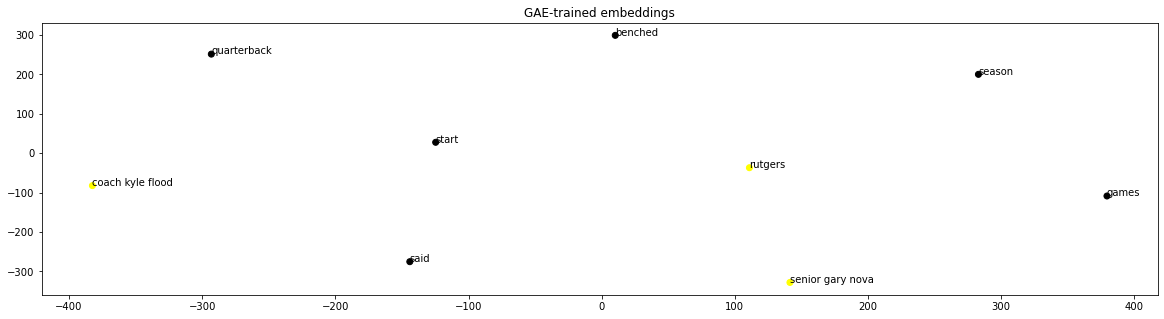

In [49]:
color_list = ['black', 'yellow']
model.eval()
z = model.encode(data.x, data.edge_index)
colors = [color_list[int(y.item())] for y in data.y]
xs, ys = zip(*TSNE(random_state=42).fit_transform(z.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(xs, ys, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (xs[i], ys[i]))

plt.title('GAE-trained embeddings')
plt.show()

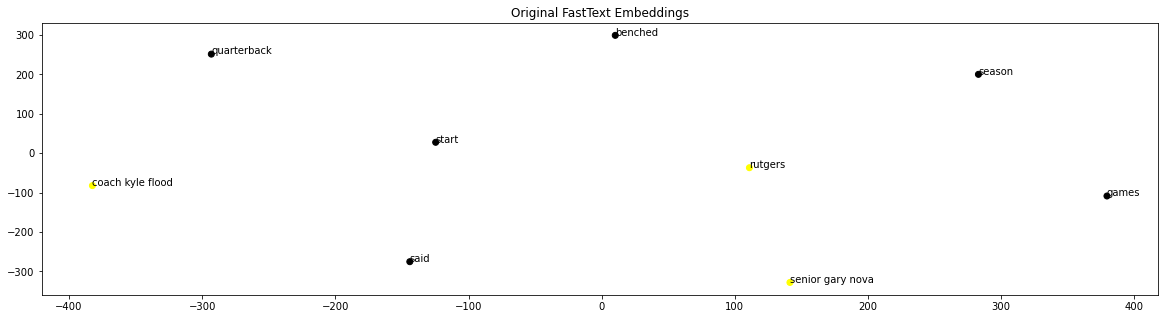

In [50]:
x_ax, y_ax = zip(*TSNE(random_state=42).fit_transform(x.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(x_ax, y_ax, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (x_ax[i], y_ax[i]))
plt.title('Original FastText Embeddings')
plt.show()

### Training a node classifier

In [51]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [52]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index#, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        #if self.task == 'graph':
        #    x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label.type(torch.LongTensor))

In [53]:
def get_accuracy(preds, targets):
    
    preds = preds.argmax(dim=1)
    ncorrects = preds.eq(targets).sum().item()
    return ncorrects / len(targets)

In [54]:
def train_node_clf(dataset, 
          #writer
         verbose=False):
    
    # build model
    model = GNNStack(max(dataset.x.shape[1], 1), 32, 2, 
                     task='node')
    opt = optim.Adam(model.parameters(), lr=0.01)
    #import pdb;pdb.set_trace()
    # train
    model.train()
    label = data.y
    losses = []
    accuracies = []
    for epoch in range(500):
        
        #print(batch.train_mask, '----')
        opt.zero_grad()
        embedding, pred = model(data)
        #pred = pred[batch.train_mask]
        #label = label[batch.train_mask]
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        #total_loss += loss.item()
        acc = get_accuracy(pred, label)
        losses.append(loss.item())
        accuracies.append(acc)
        if verbose:
            print('Epoch', epoch)
            print('Loss', loss.item())

            print('Accuracy', acc)
            print('#########################################################')
        

        #writer.add_scalar("loss", total_loss, epoch)
        #writer.add_scalar("test accuracy", test_acc, epoch)

    return model, losses, accuracies


In [55]:
%pdb off

Automatic pdb calling has been turned OFF


In [56]:
model, losses, accs = train_node_clf(data)

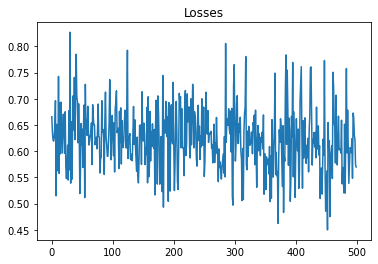

In [57]:
plt.plot(range(500), losses)
plt.title('Losses');

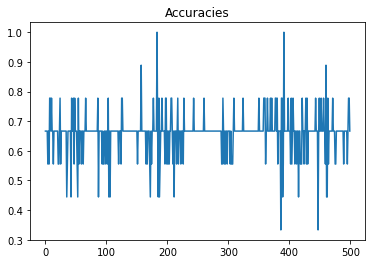

In [58]:
plt.plot(range(500), accs)
plt.title('Accuracies');

In [59]:
model.eval()
with torch.no_grad():
    embed, preds = model(data)

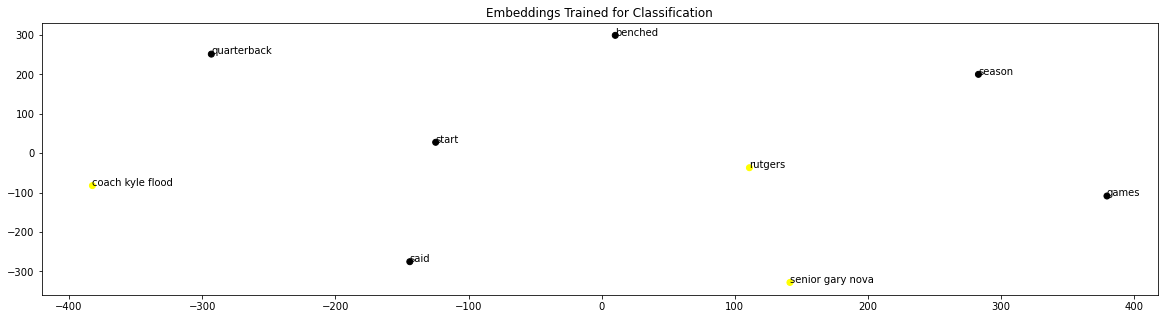

In [60]:
x_emb, y_emb = zip(*TSNE(random_state=42).fit_transform(embed.detach().numpy()))

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(x_emb, y_emb, color=colors)

for i, tupel in enumerate(word_map):
    ax.annotate(tupel[0], (x_emb[i], y_emb[i]))
plt.title('Embeddings Trained for Classification')
plt.show()

In [61]:
preds.argmax(dim=1), data.y

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1.]))

### Training GAT classifier

In [62]:
class GraphAttentionLayer(nn.Module):
    
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)
        a_input = self._prepare_attentional_mechanism_input(Wh)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        N = Wh.size()[0] # number of nodes

        # Below, two matrices are created that contain embeddings in their rows in different orders.
        # (e stands for embedding)
        # These are the rows of the first matrix (Wh_repeated_in_chunks): 
        # e1, e1, ..., e1,            e2, e2, ..., e2,            ..., eN, eN, ..., eN
        # '-------------' -> N times  '-------------' -> N times       '-------------' -> N times
        # 
        # These are the rows of the second matrix (Wh_repeated_alternating): 
        # e1, e2, ..., eN, e1, e2, ..., eN, ..., e1, e2, ..., eN 
        # '----------------------------------------------------' -> N times
        # 
        
        Wh_repeated_in_chunks = Wh.repeat_interleave(N, dim=0)
        Wh_repeated_alternating = Wh.repeat(N, 1)
        # Wh_repeated_in_chunks.shape == Wh_repeated_alternating.shape == (N * N, out_features)

        # The all_combination_matrix, created below, will look like this (|| denotes concatenation):
        # e1 || e1
        # e1 || e2
        # e1 || e3
        # ...
        # e1 || eN
        # e2 || e1
        # e2 || e2
        # e2 || e3
        # ...
        # e2 || eN
        # ...
        # eN || e1
        # eN || e2
        # eN || e3
        # ...
        # eN || eN

        all_combinations_matrix = torch.cat([Wh_repeated_in_chunks, Wh_repeated_alternating], dim=1)
        # all_combinations_matrix.shape == (N * N, 2 * out_features)

        return all_combinations_matrix.view(N, N, 2 * self.out_features)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [63]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, 
                                               nhid, 
                                               dropout=dropout, 
                                               alpha=alpha, 
                                               concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, 
                                           dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        #import pdb;pdb.set_trace()
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

In [64]:
# Model and optimizer
modelGAT = GAT(
    nfeat=data.num_node_features, 
    nhid=32, 
    nclass=2, 
    dropout=0.5, 
    nheads=2, 
    alpha=0.3
)
optimizerGAT = optim.Adam(
    modelGAT.parameters(), 
    lr=2e-4, 
    #weight_decay=args.weight_decay
)

In [65]:
def trainGAT(x, adj, label, nepochs, model, opt, verbose=False):
    
    model.train()
    losses = []
    accuracies = []
    
    for epoch in range(nepochs):
        
        opt.zero_grad()
        preds = model(x, adj)
        
        loss = F.nll_loss(preds, label.type(torch.LongTensor))
        loss.backward()
        opt.step()

        acc = get_accuracy(preds, label)
        losses.append(loss.item())
        accuracies.append(acc)
        if verbose:
            print('Epoch', epoch)
            print('Loss', loss.item())

            print('Accuracy', acc)
            print('#########################################################')
        
        # * batch.num_graphs
        #total_loss /= len(loader.dataset)
        #writer.add_scalar("loss", total_loss, epoch)

        #if epoch % 10 == 0:
        #    test_acc = test(test_loader, model)
        #    print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
        #        epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)

    return model, losses, accuracies


In [66]:
data_adj = torch.from_numpy(nx.adjacency_matrix(G).toarray())
gat, gat_loss, gat_acc = trainGAT(data.x, data_adj, data.y,
                                  100, modelGAT, optimizerGAT)

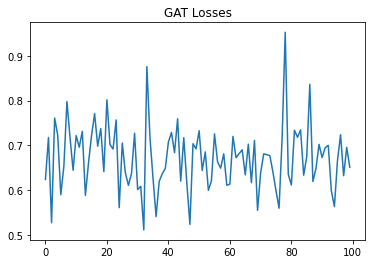

In [67]:
plt.plot(range(100), gat_loss)
plt.title('GAT Losses');

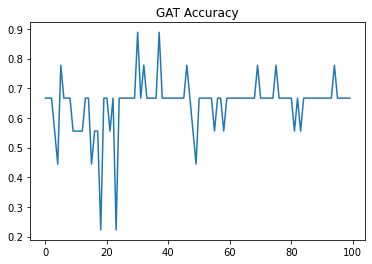

In [68]:
plt.plot(range(100), gat_acc)
plt.title('GAT Accuracy');

In [69]:
modelGAT.eval()
with torch.no_grad():
    print(modelGAT(data.x, data_adj).argmax(dim=1))
    print(data.y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1.])
